<div class="alert" style="background-color:#fff; color:white; padding:0px 10px; border-radius:5px;"><h1 style='margin:15px 15px; color:#006a79; font-size:40px'>Predicting Rush Or Pass LightGBM Model</h1>
</div>

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Setup Environment</h2>
</div>

In [41]:
#Import Libraries
import pandas as pd
import numpy as np
import nfl_data_py as nfl

pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 500)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import lightgbm as lgb

from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import ConfusionMatrixDisplay
from lightgbm import LGBMClassifier
from lightgbm import early_stopping, log_evaluation

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Load Data</h2>
</div>

In [21]:
years = [2024]
play_by_play = nfl.import_pbp_data(years, downcast=True, cache=False)

2024 done.
Downcasting floats.


<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Preview Data</h2>
</div>

In [22]:
play_by_play.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49492 entries, 0 to 49491
Columns: 372 entries, play_id to pass_oe
dtypes: float32(199), int32(7), int64(1), object(165)
memory usage: 101.6+ MB


In [23]:
play_by_play.describe()

,play_id,week,yardline_100,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,quarter_end,drive,sp,qtr,down,goal_to_go,ydstogo,ydsnet,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,air_yards,yards_after_catch,kick_distance,home_timeouts_remaining,away_timeouts_remaining,timeout,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,posteam_score_post,defteam_score_post,score_differential_post,no_score_prob,opp_fg_prob,opp_safety_prob,opp_td_prob,fg_prob,safety_prob,td_prob,extra_point_prob,two_point_conversion_prob,ep,epa,total_home_epa,total_away_epa,total_home_rush_epa,total_away_rush_epa,total_home_pass_epa,total_away_pass_epa,air_epa,yac_epa,comp_air_epa,comp_yac_epa,total_home_comp_air_epa,total_away_comp_air_epa,total_home_comp_yac_epa,total_away_comp_yac_epa,total_home_raw_air_epa,total_away_raw_air_epa,total_home_raw_yac_epa,total_away_raw_yac_epa,wp,def_wp,home_wp,away_wp,wpa,vegas_wpa,vegas_home_wpa,home_wp_post,away_wp_post,vegas_wp,vegas_home_wp,total_home_rush_wpa,total_away_rush_wpa,total_home_pass_wpa,total_away_pass_wpa,air_wpa,yac_wpa,comp_air_wpa,comp_yac_wpa,total_home_comp_air_wpa,total_away_comp_air_wpa,total_home_comp_yac_wpa,total_away_comp_yac_wpa,total_home_raw_air_wpa,total_away_raw_air_wpa,total_home_raw_yac_wpa,total_away_raw_yac_wpa,punt_blocked,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,third_down_failed,fourth_down_converted,fourth_down_failed,incomplete_pass,touchback,interception,punt_inside_twenty,punt_in_endzone,punt_out_of_bounds,punt_downed,punt_fair_catch,kickoff_inside_twenty,kickoff_in_endzone,kickoff_out_of_bounds,kickoff_downed,kickoff_fair_catch,fumble_forced,fumble_not_forced,fumble_out_of_bounds,solo_tackle,safety,penalty,tackled_for_loss,fumble_lost,own_kickoff_recovery,own_kickoff_recovery_td,qb_hit,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,rush_touchdown,return_touchdown,extra_point_attempt,two_point_attempt,field_goal_attempt,kickoff_attempt,punt_attempt,fumble,complete_pass,assist_tackle,lateral_reception,lateral_rush,lateral_return,lateral_recovery,passing_yards,receiving_yards,rushing_yards,lateral_receiving_yards,lateral_rushing_yards,tackle_with_assist,fumble_recovery_1_yards,fumble_recovery_2_yards,return_yards,penalty_yards,replay_or_challenge,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv,season,cp,cpoe,series,series_success,order_sequence,play_deleted,special_teams_play,fixed_drive,drive_play_count,drive_first_downs,drive_inside20,drive_ended_with_score,drive_quarter_start,drive_quarter_end,drive_yards_penalized,drive_play_id_started,drive_play_id_ended,away_score,home_score,result,total,spread_line,total_line,div_game,temp,wind,aborted_play,success,passer_jersey_number,rusher_jersey_number,receiver_jersey_number,pass,rush,first_down,special,play,jersey_number,out_of_bounds,home_opening_kickoff,qb_epa,xyac_epa,xyac_mean_yardage,xyac_median_yardage,xyac_success,xyac_fd,xpass,pass_oe
count,49492.000000,49492.000000,45950.000000,49487.000000,49487.000000,49487.000000,49492.000000,48929.000000,49492.000000,49492.000000,41483.000000,49492.000000,49492.000000,48929.000000,47975.000000,49492.000000,49492.00000,48032.000000,49492.000000,49492.000000,49492.000000,18580.000000,12136.000000,7536.000000,49492.000000,49492.000000,47975.000000,46779.000000,46779.000000,49492.000000,49492.000000,46779.000000,46779.000000,46779.000000,46779.000000,46779.000000,46779.000000,49492.000000,49492.000000,49492.000000,49492.000000,49492.000000,49492.000000,49492.000000,49492.000000,49492.000000,48922.000000,48922.000000,49492.000000,49492.000000,49492.000000,49492.000000,49492.000000,49492.000000,18505.000000,18505.000000,47975.000000,47975.000000,49492.000000,49492.000000,49492.000000,49492.000000,49492.000000,49492.000000,49492.000000,49492.000000,49207.000000,4

In [24]:
play_by_play.head()

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,drive,sp,qtr,down,goal_to_go,time,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,field_goal_result,kick_distance,extra_point_result,two_point_conv_result,home_timeouts_remaining,away_timeouts_remaining,timeout,timeout_team,td_team,td_player_name,td_player_id,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,posteam_score_post,defteam_score_post,score_differential_post,no_score_prob,opp_fg_prob,opp_safety_prob,opp_td_prob,fg_prob,safety_prob,td_prob,extra_point_prob,two_point_conversion_prob,ep,epa,total_home_epa,total_away_epa,total_home_rush_epa,total_away_rush_epa,total_home_pass_epa,total_away_pass_epa,air_epa,yac_epa,comp_air_epa,comp_yac_epa,total_home_comp_air_epa,total_away_comp_air_epa,total_home_comp_yac_epa,total_away_comp_yac_epa,total_home_raw_air_epa,total_away_raw_air_epa,total_home_raw_yac_epa,total_away_raw_yac_epa,wp,def_wp,home_wp,away_wp,wpa,vegas_wpa,vegas_home_wpa,home_wp_post,away_wp_post,vegas_wp,vegas_home_wp,total_home_rush_wpa,total_away_rush_wpa,total_home_pass_wpa,total_away_pass_wpa,air_wpa,yac_wpa,comp_air_wpa,comp_yac_wpa,total_home_comp_air_wpa,total_away_comp_air_wpa,total_home_comp_yac_wpa,total_away_comp_yac_wpa,total_home_raw_air_wpa,total_away_raw_air_wpa,total_home_raw_yac_wpa,total_away_raw_yac_wpa,punt_blocked,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,third_down_failed,fourth_down_converted,fourth_down_failed,incomplete_pass,touchback,interception,punt_inside_twenty,punt_in_endzone,punt_out_of_bounds,punt_downed,punt_fair_catch,kickoff_inside_twenty,kickoff_in_endzone,kickoff_out_of_bounds,kickoff_downed,kickoff_fair_catch,fumble_forced,fumble_not_forced,fumble_out_of_bounds,solo_tackle,safety,penalty,tackled_for_loss,fumble_lost,own_kickoff_recovery,own_kickoff_recovery_td,qb_hit,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,rush_touchdown,return_touchdown,extra_point_attempt,two_point_attempt,field_goal_attempt,kickoff_attempt,punt_attempt,fumble,complete_pass,assist_tackle,lateral_reception,lateral_rush,lateral_return,lateral_recovery,passer_player_id,passer_player_name,passing_yards,receiver_player_id,receiver_player_name,receiving_yards,rusher_player_id,rusher_player_name,rushing_yards,lateral_receiver_player_id,lateral_receiver_player_name,lateral_receiving_yards,lateral_rusher_player_id,lateral_rusher_player_name,lateral_rushing_yards,lateral_sack_player_id,lateral_sack_player_name,interception_player_id,interception_player_name,lateral_interception_player_id,lateral_interception_player_name,punt_returner_player_id,punt_returner_player_name,lateral_punt_returner_player_id,lateral_punt_returner_player_name,kickoff_returner_player_name,kickoff_returner_player_id,lateral_kickoff_returner_player_id,lateral_kickoff_returner_player_name,punter_player_id,punter_player_name,kicker_player_name,kicker_player_id,own_kickoff_recovery_player_id,own_kickoff_recovery_player_name,blocked_player_id,blocked_player_name,tackle_for_loss_1_player_id,tackle_for_loss_1_player_name,tackle_for_loss_2_player_id,tackle_for_loss_2_player_name,qb_hit_1_player_id,qb_hit_1_player_name,qb_hit_2_player_id,qb_hit_2_player_name,forced_fumble_player_1_team,forced_fumble_player_1_player_id,forced_fumble_player_1_player_name,forced_fumble_player_2_team,forced_fumble_player_2_player_id,forced_fumble_player_2_player_name,solo_tackle_1_team,solo_tackle_2_team,solo_tackle_1_player_id,solo_tackle_2_player_id,solo_tackle_1_player_name,solo_tackle_2_player_name,assist_tackle_1_player_id,assist_tackle_1_player_name,assist_tackle_1_team,assist_tack

In [25]:
play_by_play.head(20).to_csv("pbp_first20.csv", index=False)

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Data preprocessing (label creation + basic cleaning)</h2>
</div>

In [26]:
# let's drop few columns which won't contribute to the model using ball knowledge (TODO)
# churn_data.drop(['CustomerId','Surname'],axis=1,inplace=True)

In [27]:
play_by_play["play_type"].value_counts(dropna=False)

pass           20006
run            15044
no_play         4934
kickoff         2949
punt            2119
NaN             1460
extra_point     1302
field_goal      1166
qb_kneel         437
qb_spike          75
Name: play_type, dtype: int64

In [28]:
# normalize the play_type string (safe for NaN)
play_by_play['play_type_norm'] = play_by_play['play_type'].astype(str).str.strip().str.lower()

# strict mapping: only exact 'pass' and 'run' become those classes; everything else -> 'other'
def simple_map(x):
    if x == 'pass':
        return 'pass'
    if x == 'run':
        return 'run'
    return 'other'

play_by_play['play_type_simple'] = play_by_play['play_type_norm'].apply(simple_map).astype('category')

# print counts
print("Counts:")
print(play_by_play['play_type_simple'].value_counts(dropna=False))

# drop intermediate column play_type_norm
play_by_play.drop(['play_type_norm'],axis=1,inplace=True)

Counts:
pass     20006
run      15044
other    14442
Name: play_type_simple, dtype: int64


In [29]:
# add next play type by first sorting and grouping
play_by_play["down_sort"] = play_by_play["down"].fillna(0)  # NaN downs (kickoffs/returns) become 0
play_by_play_sorted = play_by_play.sort_values(
    by=["game_id", "game_seconds_remaining", "down_sort", "play_id"],
    ascending=[True, False, True, True]
).drop(columns="down_sort")

# then grouping
play_by_play_sorted["next_play_type"] = (
    play_by_play_sorted.groupby("game_id")["play_type_simple"]
      .shift(-1)   # shift backwards → next row’s play_type
)

play_by_play_sorted["next_play_type"]

0        other
1          run
2         pass
3         pass
4          run
         ...  
49487    other
49488    other
49489    other
49490    other
49491      NaN
Name: next_play_type, Length: 49492, dtype: category
Categories (3, object): ['other', 'pass', 'run']

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Model Building</h2>
</div>

In [30]:
# Keep only rows where NEXT play is run or pass; build binary label (pass=1, rush=0)
play_by_play_sorted = play_by_play_sorted[play_by_play_sorted["next_play_type"].isin(["pass", "run"])].copy()
y = (play_by_play_sorted["next_play_type"] == "pass").astype(int)

# Drop target column
drop_cols = [
    "next_play_type"
]
X = play_by_play_sorted.drop(columns=[c for c in drop_cols if c in play_by_play_sorted.columns])

In [31]:
# Split by game
groups = play_by_play_sorted["game_id"] if "game_id" in play_by_play_sorted.columns else pd.Series(np.arange(len(play_by_play_sorted)))
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# We’ll encode after splitting to avoid leakage from encoders (fit on train only)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

In [32]:
# Splitting the dataset into the Training set and Test set
X_train_raw, X_test_raw = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [33]:
# Categorical handling for LightGBM
obj_cols = X_train_raw.select_dtypes(include=["object"]).columns
for c in obj_cols:
    X_train_raw[c] = X_train_raw[c].astype("category")
    X_test_raw[c]  = X_test_raw[c].astype("category")

# Keep track of categorical column names (LightGBM sklearn wrapper accepts names)
categorical_cols = list(X_train_raw.select_dtypes(include=["category"]).columns)

In [34]:
# Train LightGBM with early stopping
clf = LGBMClassifier(
    n_estimators=2000,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    n_jobs=-1
)

clf.fit(
    X_train_raw, y_train,
    eval_set=[(X_test_raw, y_test)],
    eval_metric="logloss",
    categorical_feature=categorical_cols,
    callbacks=[early_stopping(100), log_evaluation(50)]   # replaces early_stopping_rounds & verbose
)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 15945, number of negative: 12084
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45505
[LightGBM] [Info] Number of data points in the train set: 28029, number of used features: 338
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568875 -> initscore=0.277263
[LightGBM] [Info] Start training from score 0.277263
Training until validation scores don't improve for 100 rounds
[50]	valid_0's binary_logloss: 0.613558
[100]	valid_0's binary_logloss: 0.63149
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.610887


LGBMClassifier(learning_rate=0.05, n_estimators=2000, n_jobs=-1,
               random_state=42)

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Predictions and Performance Metric</h2>
</div>

In [35]:
y_pred = clf.predict(X_test_raw)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["rush","pass"]))

Accuracy: 0.6590229312063809
F1: 0.7093954843408595
Confusion matrix:
 [[1705 1255]
 [1139 2922]]
              precision    recall  f1-score   support

        rush       0.60      0.58      0.59      2960
        pass       0.70      0.72      0.71      4061

    accuracy                           0.66      7021
   macro avg       0.65      0.65      0.65      7021
weighted avg       0.66      0.66      0.66      7021



#### `Summary` : 

Overall Accuracy

Accuracy: ~66%
This means the model correctly predicted whether the next play was a pass or a rush 2 out of 3 times. Not bad for a first attempt with no engineered features.

⚖️ Class-by-Class Performance

Rush Plays (label = 0):

Precision: 0.60 (6 of 10 predicted rushes were correct)

Recall: 0.58 (it only caught ~58% of actual rush plays)

F1-score: 0.59

Pass Plays (label = 1):

Precision: 0.70 (7 of 10 predicted passes were correct)

Recall: 0.72 (it caught ~72% of actual pass plays)

F1-score: 0.71

👉 The model is currently better at predicting passes than rushes. It tends to miss rushes (predicting pass instead).

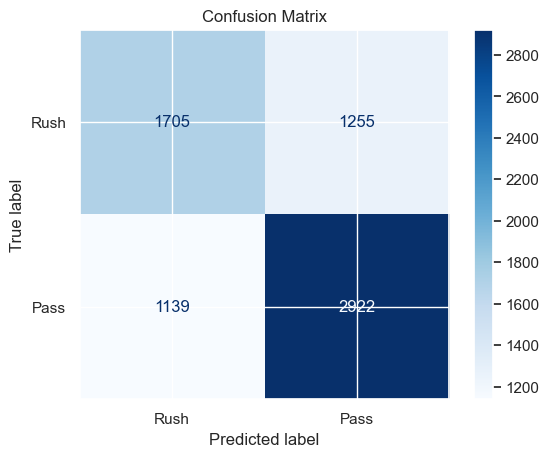

In [42]:
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=["Rush","Pass"], cmap="Blues"
)
plt.title("Confusion Matrix")
plt.show()

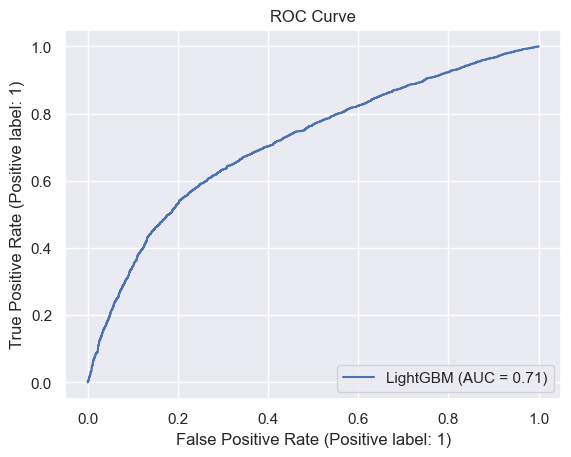

In [36]:
RocCurveDisplay.from_estimator(clf, X_test_raw, y_test, name="LightGBM")
plt.title("ROC Curve")
plt.show()

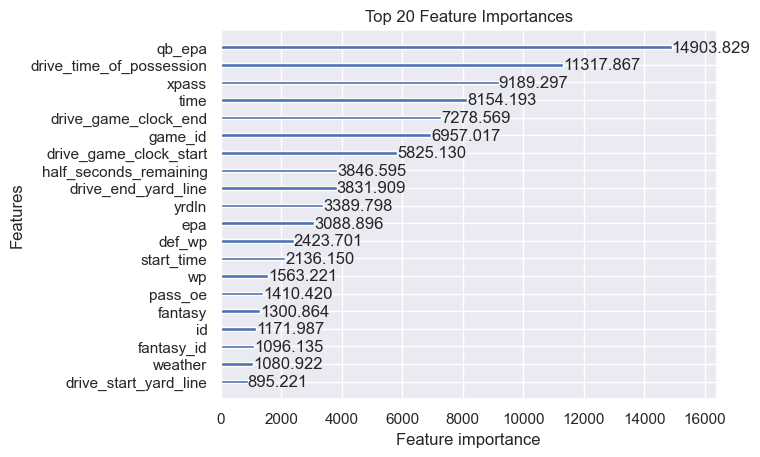

In [37]:
lgb.plot_importance(clf, max_num_features=20, importance_type="gain")
plt.title("Top 20 Feature Importances")
plt.show()

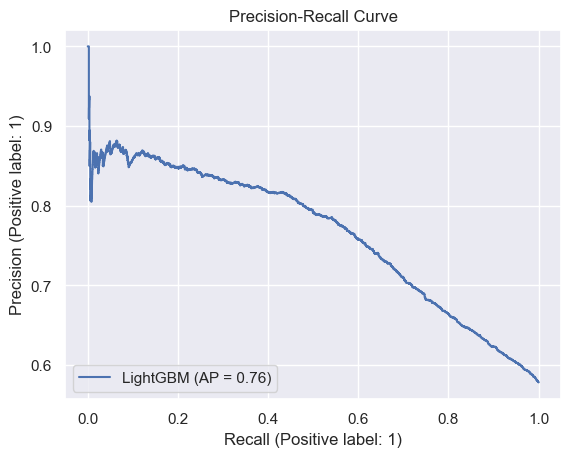

In [39]:
PrecisionRecallDisplay.from_estimator(clf, X_test_raw, y_test, name="LightGBM")
plt.title("Precision-Recall Curve")
plt.show()